In [33]:
library(Seurat)
#library(CellChat)
library(Matrix)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [1]:
cell_chat_prediction = function(cellchat)
{
    cellchat <- setIdent(cellchat, ident.use = "annotation") # set "labels" as default cell identity
    levels(cellchat@idents) # show factor levels of the cell labels
    groupSize <- as.numeric(table(cellchat@idents)) # number of cells in each cell group

    # set the ligand-receptor interaction database
    CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
    showDatabaseCategory(CellChatDB)

    dplyr::glimpse(CellChatDB$interaction)

    # use a subset of CellChatDB for cell-cell communication analysis
    #CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation") # use Secreted Signaling
    # use all CellChatDB for cell-cell communication analysis
    CellChatDB.use <- CellChatDB # simply use the default CellChatDB

    # set the used database in the object
    cellchat@DB <- CellChatDB.use

    cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database
    future::plan("multisession", workers = 8) # do parallel
    options(future.globals.maxSize = 2000 * 10000000^2)  # Setting limit to 2 GiB

    cellchat <- identifyOverExpressedGenes(cellchat)
    cellchat <- identifyOverExpressedInteractions(cellchat)

    cellchat <- computeCommunProb(cellchat, type = "triMean")
    cellchat <- filterCommunication(cellchat, min.cells = 2)
    cellchat <- computeCommunProbPathway(cellchat)
    cellchat <- aggregateNet(cellchat)
    
    return(cellchat)
}

Attaching SeuratObject

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2



In [6]:
packageVersion("Seurat")

[1] ‘4.3.0.1’

Rows: 3,249
Columns: 28
$ interaction_name         <chr> "TGFB1_TGFBR1_TGFBR2", "TGFB2_TGFBR1_TGFBR2",…
$ pathway_name             <chr> "TGFb", "TGFb", "TGFb", "TGFb", "TGFb", "TGFb…
$ ligand                   <chr> "TGFB1", "TGFB2", "TGFB3", "TGFB1", "TGFB1", …
$ receptor                 <chr> "TGFbR1_R2", "TGFbR1_R2", "TGFbR1_R2", "ACVR1…
$ agonist                  <chr> "TGFb agonist", "TGFb agonist", "TGFb agonist…
$ antagonist               <chr> "TGFb antagonist", "TGFb antagonist", "TGFb a…
$ co_A_receptor            <chr> "", "", "", "", "", "", "", "", "", "", "", "…
$ co_I_receptor            <chr> "TGFb inhibition receptor", "TGFb inhibition …
$ evidence                 <chr> "KEGG: hsa04350", "KEGG: hsa04350", "KEGG: hs…
$ annotation               <chr> "Secreted Signaling", "Secreted Signaling", "…
$ interaction_name_2       <chr> "TGFB1 - (TGFBR1+TGFBR2)", "TGFB2 - (TGFBR1+T…
$ is_neurotransmitter      <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…
$ ligand.symbol 

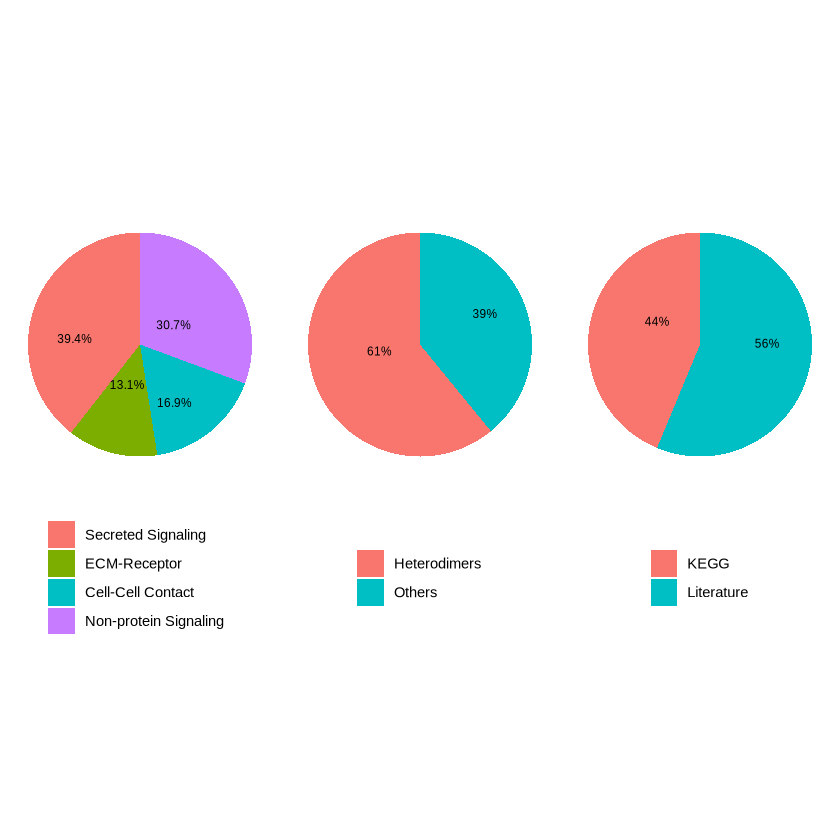

In [2]:
# set the ligand-receptor interaction database
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)
dplyr::glimpse(CellChatDB$interaction)

# use a subset of CellChatDB for cell-cell communication analysis
CellChatDB.use <- CellChatDB

In [78]:
# read the matrix
matrix = readMM("../Result/Concentric_to_R/concentric_matrix.mtx")

# read the cell and gene names
meta = read.csv("../Result/Concentric_to_R/meta_data.csv")
feature_name = read.csv("../Result/Concentric_to_R/raw_feature.csv")

rownames(matrix) = meta$X
colnames(matrix) = rownames(feature_name)

meta_info = read.csv("../Result/Concentric_to_R/meta_data.csv")

data = CreateSeuratObject(counts = t(matrix), project = "pbmc3k", min.cells = 0, min.features = 0)

# add the meta information
for (i in meta_info){
    for (i in colnames(meta_info)){
        data[[i]] = meta_info[[i]]
    }
}

In [79]:
meta = data@meta.data
meta <- meta %>%
  mutate(new_level = case_when(
    levels == "control" ~ "Control",
    levels %in% c("moderate", "advanced") ~ "Moderate",
    levels == "severe" ~ "Severe",
    TRUE ~ "Unknown"  # Fallback for any other unexpected values
  ))
data@meta.data = meta


In [80]:
data@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,X,total_counts,n_genes_by_counts,pct_counts_mt,sample_id,diagnosis,x,y,sample,levels,total_counts_mt,leiden,annotation,barcode,concentric,new_level
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
34080565498547,sample,1532.5465,538,34080565498547,835,538,2.874251,B01806B5,control,7935,4787,B01806B5,control,24,0,Ex,34080565498547,inner,Control
34046205760237,sample,1489.8153,515,34046205760237,815,515,2.699387,B01806B5,control,7927,4845,B01806B5,control,22,0,Ex,34046205760237,inner,Control
33900176872118,sample,1282.4794,417,33900176872118,653,417,8.882083,B01806B5,control,7893,4790,B01806B5,control,58,0,Ex,33900176872118,inner,Control
33797097657002,sample,1036.4141,304,33797097657002,437,304,5.949657,B01806B5,control,7869,4778,B01806B5,control,26,0,Ex,33797097657002,inner,Control
34299608830643,sample,749.3291,194,34299608830643,289,194,4.498270,B01806B5,control,7986,4787,B01806B5,control,13,0,Ex,34299608830643,inner,Control
34179349746364,sample,778.9135,205,34179349746364,300,205,4.333333,B01806B5,control,7958,4796,B01806B5,control,13,0,Ex,34179349746364,inner,Control
34175054779101,sample,983.8188,283,34175054779101,405,283,4.444444,B01806B5,control,7957,4829,B01806B5,control,18,0,Ex,34175054779101,inner,Control
35673998365433,sample,1711.8254,630,35673998365433,932,630,3.862661,B01806B5,control,8306,4857,B01806B5,control,36,0,Ex,35673998365433,inner,Control
35527969477349,sample,1568.2225,553,35527969477349,816,553,3.676471,B01806B5,control,8272,4837,B01806B5,control,30,0,Ex,35527969477349,inner,Control


In [93]:
# find the markers for inner and outer2 in Ex
sub = subset(data, subset = new_level == "Severe" & annotation == "Opc")
Idents(sub) = sub@meta.data$concentric
markers <- FindMarkers(
    sub, 
    ident.1 = "inner", 
    ident.2 = "outer2",
    test.use = "t",
    only.pos = TRUE
)

In [94]:
markers[markers$p_val_adj < 0.05,]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CLASP2,2.168680e-08,0.5682731,0.129,0,0.001130403
SLC17A7,6.209419e-08,0.5131088,0.120,0,0.003236597
AC093512.2,6.604744e-08,0.5314375,0.120,0,0.003442657
CTNND2,6.925527e-08,0.5387012,0.120,0,0.003609862
NRXN3,7.227392e-08,0.5323276,0.120,0,0.003767206
CNP,2.284211e-07,0.5185379,0.112,0,0.011906220
TMSB4X,3.906602e-07,0.4910220,0.107,0,0.020362770
SCAMP5,6.201355e-07,0.4680956,0.103,0,0.032323941
SLC44A1,6.360864e-07,0.4794057,0.103,0,0.033155366


In [73]:
# read the matrix
matrix = readMM("../Result/Concentric_to_R/concentric_outer3_all.mtx")

# read the cell and gene names
meta = read.csv("../Result/Concentric_to_R/outer3_meta_data.csv")
feature_name = read.csv("../Result/Concentric_to_R/raw_feature.csv")

rownames(matrix) = meta$X
colnames(matrix) = rownames(feature_name)

meta_info = read.csv("../Result/Concentric_to_R/outer3_meta_data.csv")

data = CreateSeuratObject(counts = t(matrix), project = "pbmc3k", min.cells = 0, min.features = 0)

# add the meta information
for (i in meta_info){
    for (i in colnames(meta_info)){
        data[[i]] = meta_info[[i]]
    }
}

In [74]:
meta_info = read.csv("../Result/Concentric_to_R/meta_data.csv")

meta_sub = meta_info[,c("barcode", "concentric")]

meta_all = data@meta.data
meta_all$concentric = NULL

meta_df <- merge(meta_all, meta_sub, by = "barcode", all.x = TRUE)

sub = subset(meta_df, annotation == "Ex" & levels == "severe" & concentric == "inner")

meta_df$concentric[is.na(meta_df$concentric)] <- "outer3"

for (i in meta_df){
    for (i in colnames(meta_df)){
        data[[i]] = meta_df[[i]]
    }
}

In [75]:
unique(data$concentric)

[1] "outer3" "outer"  "outer2" "inner"

In [76]:
Ex = subset(data, subset = annotation == "Ex" & levels == "control")
unique(Ex$concentric)

[1] "outer3" "outer"  "outer2" "inner"

In [77]:
Idents(Ex) = Ex$concentric
table = FindMarkers(
    Ex,
    ident.1 = "inner", 
    ident.2 = "outer3", 
    logfc.threshold = 0, 
    test.use = "t", 
    only.pos = TRUE,
    min.pct = 0.1
)

subset(table, table$p_val_adj < 0.05)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SLCO5A1,1.315289e-45,0.21798538,0.315,0.232,6.855811e-41
MT-CO1,2.949068e-11,0.05857160,0.724,0.694,1.537172e-06
GJA1,1.280392e-10,0.09450053,0.122,0.095,6.673915e-06
AL669831.3,1.074092e-09,0.08401215,0.130,0.103,5.598599e-05
CPLX2,1.877475e-09,0.08685893,0.178,0.148,9.786152e-05
BSG,4.811319e-08,0.07701320,0.148,0.122,2.507852e-03
ATP1B1,8.623470e-08,0.07336274,0.354,0.321,4.494898e-03
PTK2B,9.185413e-08,0.07460295,0.143,0.118,4.787805e-03
NCDN,1.541915e-07,0.07169831,0.335,0.301,8.037079e-03


In [42]:
table(Ex$concentric)


 inner  outer outer2 outer3 
  6888   9772  12983 132318 

In [132]:
Ex = subset(data, subset = annotation == "Ex")
Ex = subset(Ex, subset = levels == "advanced")
Ex = subset(Ex, subset = concentric == "outer3")
Ex

An object of class Seurat 
52124 features across 22669 samples within 1 assay 
Active assay: RNA (52124 features, 0 variable features)
 2 layers present: counts, data

In [130]:
unique(Ex@meta.data$concentric)

[1] "outer3" "inner"  "outer"  "outer2"

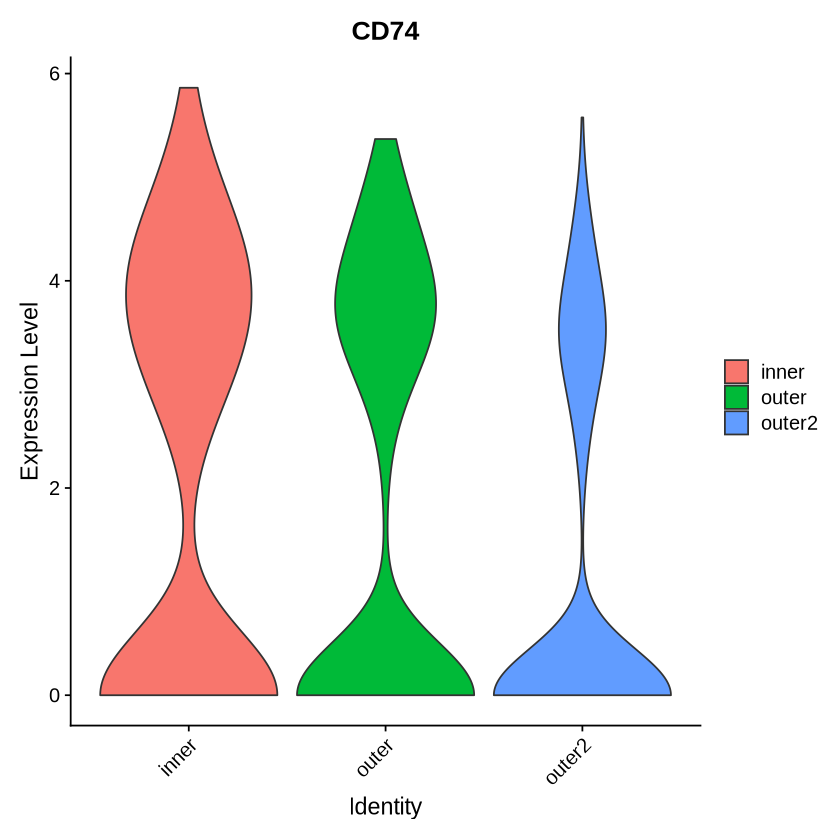

In [72]:
VlnPlot(Ast, features = "CD74", group.by = "concentric", pt.size = FALSE)

In [75]:
?FindMarkers

FindMarkers {Seurat},R Documentation
object,An object
...,Arguments passed to other methods and to specific DE methods
slot,"Slot to pull data from; note that if test.use is ""negbinom"", ""poisson"", or ""DESeq2"", slot will be set to ""counts"""
counts,Count matrix if using scale.data for DE tests. This is used for computing pct.1 and pct.2 and for filtering features based on fraction expressing
cells.1,Vector of cell names belonging to group 1
cells.2,Vector of cell names belonging to group 2
features,Genes to test. Default is to use all genes
logfc.threshold,"Limit testing to genes which show, on average, at least X-fold difference (log-scale) between the two groups of cells. Default is 0.25 Increasing logfc.threshold speeds up the function, but can miss weaker signals."
test.use,"Denotes which test to use. Available options are: ""wilcox"" : Identifies differentially expressed genes between two groups of cells using a Wilcoxon Rank Sum test (default) ""bimod"" : Likelihood-ratio test for single cell gene expression, (McDavid et al., Bioinformatics, 2013) ""roc"" : Identifies 'markers' of gene expression using ROC analysis. For each gene, evaluates (using AUC) a classifier built on that gene alone, to classify between two groups of cells. An AUC value of 1 means that expression values for this gene alone can perfectly classify the two groupings (i.e. Each of the cells in cells.1 exhibit a higher level than each of the cells in cells.2). An AUC value of 0 also means there is perfect classification, but in the other direction. A value of 0.5 implies that the gene has no predictive power to classify the two groups. Returns a 'predictive power' (abs(AUC-0.5) * 2) ranked matrix of putative differentially expressed genes. ""t"" : Identify differentially expressed genes between two groups of cells using the Student's t-test. ""negbinom"" : Identifies differentially expressed genes between two groups of cells using a negative binomial generalized linear model. Use only for UMI-based datasets ""poisson"" : Identifies differentially expressed genes between two groups of cells using a poisson generalized linear model. Use only for UMI-based datasets ""LR"" : Uses a logistic regression framework to determine differentially expressed genes. Constructs a logistic regression model predicting group membership based on each feature individually and compares this to a null model with a likelihood ratio test. ""MAST"" : Identifies differentially expressed genes between two groups of cells using a hurdle model tailored to scRNA-seq data. Utilizes the MAST package to run the DE testing. ""DESeq2"" : Identifies differentially expressed genes between two groups of cells based on a model using DESeq2 which uses a negative binomial distribution (Love et al, Genome Biology, 2014).This test does not support pre-filtering of genes based on average difference (or percent detection rate) between cell groups. However, genes may be pre-filtered based on their minimum detection rate (min.pct) across both cell groups. To use this method, please install DESeq2, using the instructions at https://bioconductor.org/packages/release/bioc/html/DESeq2.html"
min.pct,only test genes that are detected in a minimum fraction of min.pct cells in either of the two populations. Meant to speed up the function by not testing genes that are very infrequently expressed. Default is 0.1


In [ ]:
# pseudobulk RNA seq

In [52]:
pseudo_ifnb <- AggregateExpression(
    data, 
    assays = "RNA", 
    return.seurat = T, 
    group.by = c("levels", "concentric", "annotation")
)

Centering and scaling data matrix



In [53]:
pseudo_ifnb$celltype_con <- paste(pseudo_ifnb$annotation, pseudo_ifnb$concentric, sep = "_")

ERROR: [1m[33mError[39m in `x[[i, drop = TRUE]]`:[22m
[33m![39m ‘annotation’ not found in this Seurat object
 


In [55]:
tail(Cells(pseudo_ifnb))

[1] "severe_outer3_End" "severe_outer3_Ex"  "severe_outer3_Inh"
[4] "severe_outer3_Mic" "severe_outer3_Oli" "severe_outer3_Opc"

In [58]:
pseudo_ifnb$celltype_con = rownames(pseudo_ifnb@meta.data)

In [60]:
unique(rownames(pseudo_ifnb@meta.data))

[1] "advanced_inner_Ast"  "advanced_inner_End"  "advanced_inner_Ex"  
  [4] "advanced_inner_Inh"  "advanced_inner_Mic"  "advanced_inner_Oli" 
  [7] "advanced_inner_Opc"  "advanced_outer_Ast"  "advanced_outer_End" 
 [10] "advanced_outer_Ex"   "advanced_outer_Inh"  "advanced_outer_Mic" 
 [13] "advanced_outer_Oli"  "advanced_outer_Opc"  "advanced_outer2_Ast"
 [16] "advanced_outer2_End" "advanced_outer2_Ex"  "advanced_outer2_Inh"
 [19] "advanced_outer2_Mic" "advanced_outer2_Oli" "advanced_outer2_Opc"
 [22] "advanced_outer3_Ast" "advanced_outer3_End" "advanced_outer3_Ex" 
 [25] "advanced_outer3_Inh" "advanced_outer3_Mic" "advanced_outer3_Oli"
 [28] "advanced_outer3_Opc" "control_inner_Ast"   "control_inner_End"  
 [31] "control_inner_Ex"    "control_inner_Inh"   "control_inner_Mic"  
 [34] "control_inner_Oli"   "control_inner_Opc"   "control_outer_Ast"  
 [37] "control_outer_End"   "control_outer_Ex"    "control_outer_Inh"  
 [40] "control_outer_Mic"   "control_outer_Oli"   "control_outer_Opc"  
 [43] "control_outer2_Ast"  "control_outer2_End"  "control_outer2_Ex"  
 [46] "control_outer2_Inh"  "control_outer2_Mic"  "control_outer2_Oli" 
 [49] "control_outer2_Opc"  "control_outer3_Ast"  "control_outer3_End" 
 [52] "control_outer3_Ex"   "control_outer3_Inh"  "control_outer3_Mic" 
 [55] "control_outer3_Oli"  "control_outer3_Opc"  "moderate_inner_Ast" 
 [58] "moderate_inner_End"  "moderate_inner_Ex"   "moderate_inner_Inh" 
 [61] "moderate_inner_Mic"  "moderate_inner_Oli"  "moderate_inner_Opc" 
 [64] "moderate_outer_Ast"  "moderate_outer_End"  "moderate_outer_Ex"  
 [67] "moderate_outer_Inh"  "moderate_outer_Mic"  "moderate_outer_Oli" 
 [70] "moderate_outer_Opc"  "moderate_outer2_Ast" "moderate_outer2_End"
 [73] "moderate_outer2_Ex"  "moderate_outer2_Inh" "moderate_outer2_Mic"
 [76] "moderate_outer2_Oli" "moderate_outer2_Opc" "moderate_outer3_Ast"
 [79] "moderate_outer3_End" "moderate_outer3_Ex"  "moderate_outer3_Inh"
 [82] "moderate_outer3_Mic" "moderate_outer3_Oli" "moderate_outer3_Opc"
 [85] "severe_inner_Ast"    "severe_inner_End"    "severe_inner_Ex"    
 [88] "severe_inner_Inh"    "severe_inner_Mic"    "severe_inner_Oli"   
 [91] "severe_inner_Opc"    "severe_outer_Ast"    "severe_outer_End"   
 [94] "severe_outer_Ex"     "severe_outer_Inh"    "severe_outer_Mic"   
 [97] "severe_outer_Oli"    "severe_outer_Opc"    "severe_outer2_Ast"  
[100] "severe_outer2_End"   "severe_outer2_Ex"    "severe_outer2_Inh"  
[103] "severe_outer2_Mic"   "severe_outer2_Oli"   "severe_outer2_Opc"  
[106] "severe_outer3_Ast"   "severe_outer3_End"   "severe_outer3_Ex"   
[109] "severe_outer3_Inh"   "severe_outer3_Mic"   "severe_outer3_Oli"  
[112] "severe_outer3_Opc"

In [65]:
Idents(pseudo_ifnb) <- "celltype_con"

bulk.mono.de <- FindMarkers(object = pseudo_ifnb, 
                         ident.1 = "control_outer2_Ex", 
                         ident.2 = "control_outer3_Ex",
                         test.use = "DESeq2")
head(bulk.mono.de, n = 15)

ERROR: Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2, : Cell group 1 has fewer than 3 cells


In [62]:
subset(data, subset = concentric == "inner" & annotation == "Ex" & levels == "control")

An object of class Seurat 
52124 features across 6888 samples within 1 assay 
Active assay: RNA (52124 features, 0 variable features)
 2 layers present: counts, data

In [63]:
pseudo_ifnb

An object of class Seurat 
52124 features across 112 samples within 1 assay 
Active assay: RNA (52124 features, 0 variable features)
 3 layers present: counts, data, scale.data